In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [516]:
# set basic parameters and subdirectory
part_n = 800
e_part_r = 0.8
e_mean = 4
excess_i = 0#10
ei_std_s = [4, 4]
waiting_time = 300
interval_len = waiting_time + 5120#1280
freq = 0

In [559]:
# generate and save parameters for simulation
seed = round(time.time())
print(seed)
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.array([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean, excess_i)
unscaled_std = jnp.tile(jnp.array([ei_std_s]), (2, 1))
connectivity_n = 1
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(
  connectivity_s_generator(sub_part_n_s, unscaled_mean, unscaled_std, jnp.array([[0]]),
                           connectivity_n,
                           key),
  sub_part_n_s, unscaled_mean, in_r, rewiring_prob)

sub_part_n_s_ext_gen = jnp.array([part_n])
ext_part_n = 1
ext_sub_part_r_s = jnp.array([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.array([[0.]])
unscaled_ext_std = jnp.array([[1.]])
ext_connectivity_n = 1###3
inter_instance_correlation = jnp.identity(ext_connectivity_n)
[ext_connectivity_s, key] = ext_connectivity_s_generator(
  sub_part_n_s_ext_gen, ext_sub_part_n_s,
  unscaled_ext_mean, unscaled_ext_std, inter_instance_correlation,
  ext_connectivity_n, 
  key)
ext_mean=0#.5
ext_connectivity_s = ext_connectivity_s + ext_mean

phase_n = 1
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
phase_s = 0 * phase_s # since freq = 0

amp_s = jnp.expand_dims(jnp.array([0, 0.6]),
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]

init_condition_n = 1
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)

label_s = jnp.array([1])
label_s_free = jnp.array([0])
time_interval_s = jnp.array([[0, interval_len]])
window_len_s = jnp.array([10, 40, 160, 640]) # used length = 1000
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24

condition_n_s = jnp.array([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.array([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

1707784070


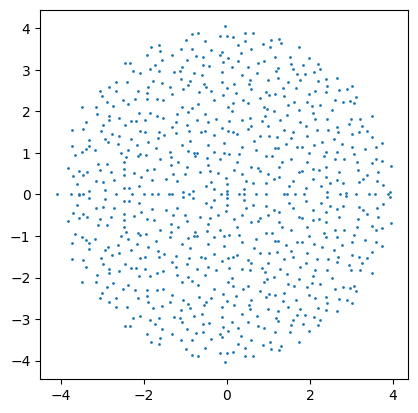

In [560]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n), squeeze = False)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[0, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[0, connectivity_idx].set_aspect('equal')

In [561]:
h_s=[0 for wave_idx in range(wave_n)]
r_s=[0 for wave_idx in range(wave_n)]

joined_time_interval = jnp.array([0, interval_len])
temp_traj_holder = traj_initializer(init_condition_s[0], joined_time_interval, resolution)
for wave_idx in range(1,wave_n):
  temp_traj = temp_traj_holder.at[..., 0].set(init_condition_s[0])
  temp_traj = rk4_ode_solver(
    lambda position:
    almlin_velocity_fct(connectivity_s[0], position),
    lambda time:
    sin_ext_input_fct(
      wave_s[wave_idx],#jnp.array([0,0]), 
      ext_connectivity_s[0], phase_s[0],
      labeled_time_interval_s, time),
    temp_traj,
    joined_time_interval[0], resolution)
  h_s[wave_idx]=temp_traj
  r_s[wave_idx]=jnp.tanh(temp_traj)

In [562]:
hhat=jnp.mean(h_s[1],axis=0)
htld=h_s[1]-hhat
nhat=hhat-jnp.mean(hhat)
ntld=htld-jnp.mean(htld,axis=1,keepdims=True)
nall=nhat+ntld

nhatvar=jnp.var(nhat)
nhattldcov=nhat@ntld.T/ntld.shape[1]
ntldcov=ntld@ntld.T/ntld.shape[1]
nallcov=nall@nall.T/ntld.shape[1]

In [563]:
rhat=jnp.mean(r_s[1],axis=0)
rtld=r_s[1]-rhat
rnhat=rhat-jnp.mean(rhat)
rntld=rtld-jnp.mean(rtld,axis=1,keepdims=True)
rnall=rnhat+rntld

rnhatvar=jnp.var(rnhat)
rnhattldcov=rnhat@rntld.T/rntld.shape[1]
rntldcov=rntld@rntld.T/rntld.shape[1]
rnallcov=rnall@rnall.T/rntld.shape[1]

-0.073113345 1.9625722


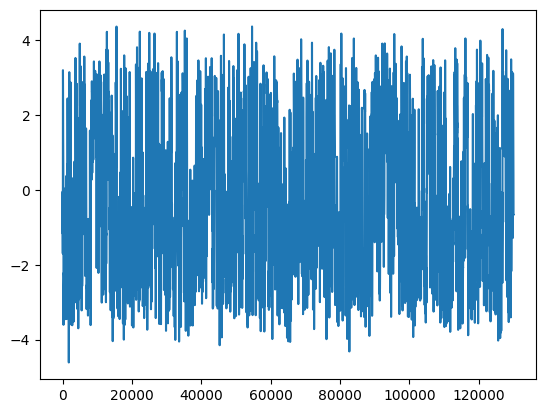

In [564]:
#params
plt.plot(hhat)
print(jnp.mean(hhat)/e_mean, jnp.std(hhat))

In [565]:
#acov
print(jnp.var(nhat), jnp.mean(jnp.var(ntld,axis=1)),
      jnp.mean(jnp.var(nhat+ntld,axis=1)))
print(jnp.var(jnp.mean(h_s[1],axis=1)-jnp.mean(hhat)))
print(jnp.var(rnhat), jnp.mean(jnp.var(rntld,axis=1)), 
      jnp.mean(jnp.var(rnhat+rntld,axis=1)))

3.8516898 4.397055 8.248744
1.7340212
0.33199996 0.35814095 0.6901409


In [566]:
#ccov
# (c2hat, c2c, c2tld)=(nhatvar**2, 
#                      jnp.mean(nhattldcov**2)*2,
#                      jnp.mean(ntldcov[jnp.triu_indices(part_n,1)]**2))
# c2tot=c2hat+c2c+c2tld
(c2hat, c2c, c2tld)=(rnhatvar**2, 
                     jnp.mean(rnhattldcov**2)*2,
                     jnp.mean(rntldcov[jnp.triu_indices(part_n,1)]**2))
c2tot=c2hat+c2c+c2tld

# print(jnp.mean(nallcov[jnp.triu_indices(part_n,1)]**2))
print(jnp.mean(rnallcov[jnp.triu_indices(part_n,1)]**2))
print(c2tot)
print(c2hat, c2c*part_n, c2tld*part_n)
# print(c2tot/c2hat)

0.11753135
0.117832296
0.11022397 4.885727 1.20093


In [567]:
#pr
(jnp.trace(rnallcov)**2/jnp.trace(rnallcov@rnallcov)/part_n,
 jnp.var(rnall)**2/(jnp.var(rnall)**2+c2hat*part_n+c2c*part_n+c2tld*part_n),
 jnp.var(rnall)**2/(jnp.var(rnall)**2+c2hat*part_n+c2c*part_n),
 jnp.var(rnall)**2/(jnp.var(rnall)**2+c2hat*part_n))

(Array(0.00504574, dtype=float32),
 Array(0.00502727, dtype=float32),
 Array(0.00509182, dtype=float32),
 Array(0.00537242, dtype=float32))

0.16125083 0.12817031 0.16502915


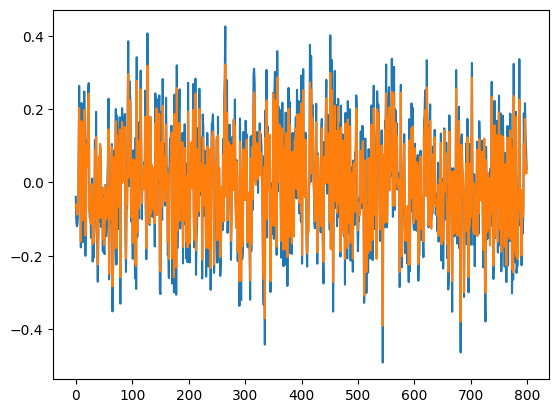

In [568]:
nhattldcorrcoef=(nhat/jnp.std(nhat))@(ntld.T / jnp.std(ntld, axis=1))/len(nhat)
rnhattldcorrcoef=(rnhat/jnp.std(rnhat))@(rntld.T / jnp.std(rntld, axis=1))/len(nhat)

jmu=connectivity_s_generator(
  sub_part_n_s, unscaled_mean, unscaled_std*0, jnp.array([[0]]),connectivity_n)[0][0]
jsig=connectivity_s[0]-jmu
xihat=(jmu@rntld)[0]
xitld=jsig@rntld

xihattldcorrcoef=(xihat/jnp.std(xihat))@(xitld.T / jnp.std(xitld, axis=1))/len(nhat)
plt.plot(nhattldcorrcoef)
plt.plot(xihattldcorrcoef)
# plt.plot(rnhattldcorrcoef)
print(jnp.std(nhattldcorrcoef), jnp.std(xihattldcorrcoef), jnp.std(rnhattldcorrcoef))

In [569]:
jnp.std(nhattldcorrcoef), jnp.var(nhat)/jnp.mean(jnp.var(ntld,axis=1)), jnp.std(nhat@ntld.T/len(nhat)*2)

(Array(0.16125083, dtype=float32),
 Array(0.8759703, dtype=float32),
 Array(1.364179, dtype=float32))

(Array(8.248744, dtype=float32), Array(8.248745, dtype=float32))

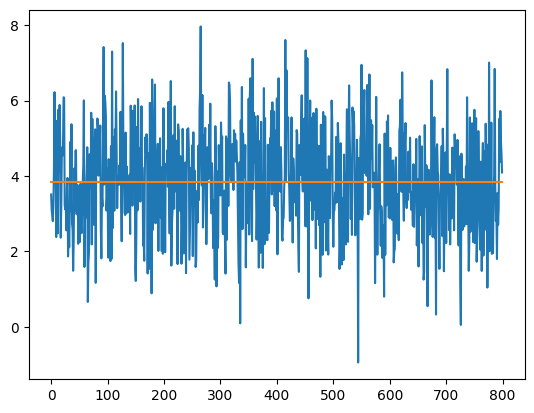

In [570]:
plt.plot(jnp.var(h_s[1],axis=1)-jnp.var(ntld,axis=1))#blue:tot-tld, should be const=hat
plt.plot(jnp.full((part_n,),jnp.var(nhat)))
# plt.plot(nhat@ntld.T/len(nhat)*2+jnp.var(nhat))
jnp.mean(jnp.var(h_s[1],axis=1)), jnp.mean(jnp.var(ntld,axis=1))+ jnp.var(nhat)

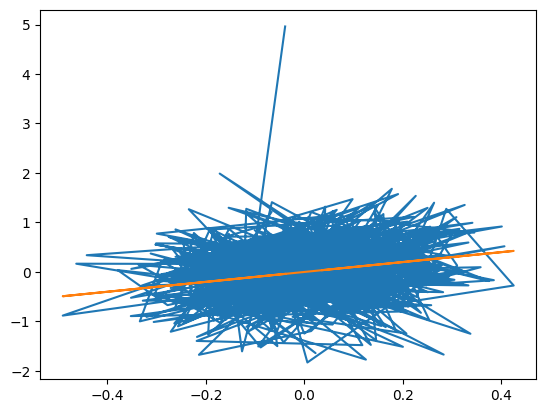

In [571]:
# plt.plot(jnp.mean(ntld[0]*ntld,axis=1))
plt.plot(nhattldcorrcoef, jnp.mean(ntld[0]*ntld,axis=1))
plt.plot(nhattldcorrcoef, nhattldcorrcoef)

22.921019 5.657667
281.41147 159.64494


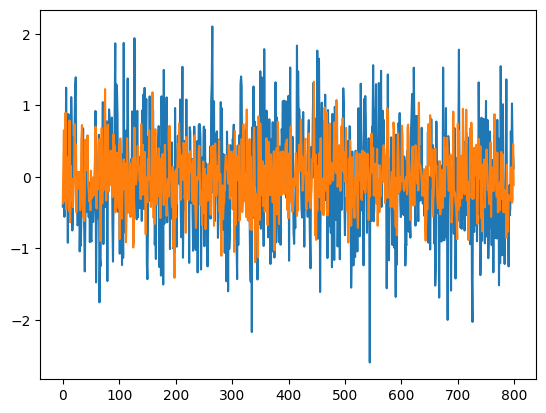

In [572]:
print(e_part_r/(1-e_part_r)*e_mean**2*jnp.var(rntld), jnp.var(xihat))
print(e_part_r/(1-e_part_r)*e_mean**2*jnp.var(ntld), jnp.var((jmu[:1]@ntld)))
# print(unscaled_std[0,0]**2*jnp.var(rntld), jnp.var(xitld))

plt.plot(jnp.mean((jmu@rntld)[:1]*(jsig@rntld),axis=1))
plt.plot((jmu*jsig)@jnp.mean(rntld*rntld,axis=1,keepdims=True))

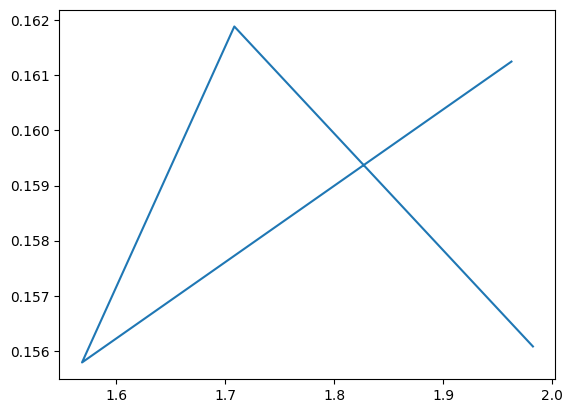

In [573]:
plt.plot([1.9822814, 1.7083292,  1.5685942, 1.9625722],
[0.15607828, 0.16188803, 0.15578738, 0.16125083])

In [ ]:
# rnhatacov=matched_correlation_fct(rnhat, rnhat, 0, 0)
# plt.plot(rnhatacov[:30*resolution])
# plt.plot(rnhatacov[:30*resolution]*c2tot/c2hat)
ns=nhat+ntld
nacov=matched_correlation_fct(ns, ns, 0, 0)
plt.plot(jnp.arange(30*resolution)/resolution, jnp.mean(nacov[:,:30*resolution],axis=0))

In [80]:
# plt.plot((connectivity_s[0]@r_s[1])[0]-(connectivity_s[0]@rtld)[0])
alphas=1-jnp.tanh(h_s[1])**2

c2xitld=jnp.mean(xitldcov[jnp.triu_indices(part_n,1)]**2)
print(jnp.mean(alphas**2)**2*c2xitld, c2tld)

alphacsqs = jnp.array([matched_correlation_fct(jnp.roll(alphas, shift, axis = 0), alphas, 
                                   0, 0)
                      for shift in jnp.arange(1,1+4)]).reshape(4*part_n, alphas.shape[1])

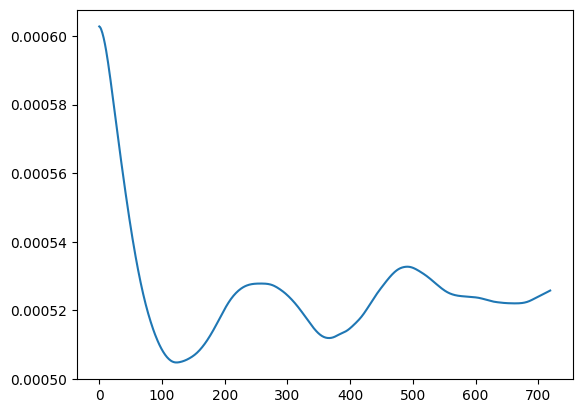

In [82]:
foo=jnp.mean(alphacsqs, axis=0)[:30*resolution]
plt.plot(foo**2)#-jnp.mean(foo)
# plt.ylim(0,0.001)
# plt.plot(rnhatacov[:30*resolution])

In [153]:
n_ccov_s = jnp.array([matched_correlation_fct(jnp.roll(nall, shift, axis = 0), nall, 
                                   0, 0)
                      for shift in jnp.arange(1,1+4)]) 

rfluct = r_s[1] - jnp.mean(r_s[1],axis=1,keepdims=True)
rfluct_ccov_s = jnp.array([matched_correlation_fct(jnp.roll(rfluct, shift, axis = 0), rfluct, 
                                   0, 0)
                      for shift in jnp.arange(1,1+4)]) 

1.4717001 1.4681818
2.1659012 2.8462515
0.14663652 0.14635874
0.021502268 0.026652638


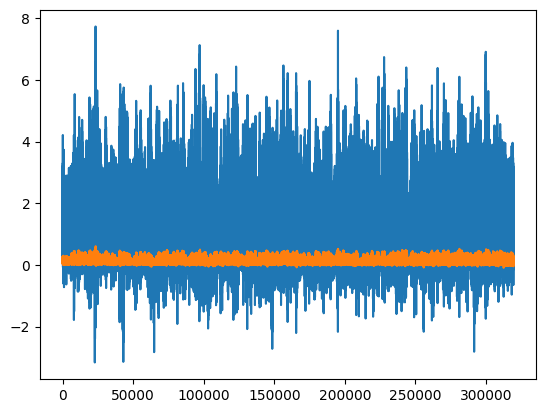

In [161]:
# plt.plot(jnp.arange(resolution * 30)/resolution, 
#          jnp.mean(hfluct_ccov_s[:,:,:resolution * 30],axis = (0,1)) ** 2)
# plt.plot(jnp.arange(resolution * 30)/resolution, hhatMacov[:resolution * 30])
print(jnp.var(hhat), 
 jnp.mean((hfluct@hfluct.T)[jnp.triu_indices(part_n, 1)]/hfluct.shape[1]))
print(jnp.var(hhat)**2, 
 jnp.mean(((hfluct@hfluct.T)[jnp.triu_indices(part_n, 1)]/hfluct.shape[1])**2))

# plt.plot(jnp.arange(resolution * 30)/resolution, 
#          jnp.mean(rfluct_ccov_s[:,:,:resolution * 30],axis = (0,1)) ** 2)
# plt.plot(jnp.arange(resolution * 30)/resolution, rhatacov[:resolution * 30])
print(jnp.var(rhat), 
 jnp.mean((rfluct@rfluct.T)[jnp.triu_indices(part_n, 1)]/rfluct.shape[1]))
print(jnp.var(rhat)**2, 
 jnp.mean(((rfluct@rfluct.T)[jnp.triu_indices(part_n, 1)]/rfluct.shape[1])**2))

plt.plot((hfluct@hfluct.T)[jnp.triu_indices(part_n, 1)]/hfluct.shape[1])
plt.plot((rfluct@rfluct.T)[jnp.triu_indices(part_n, 1)]/rfluct.shape[1])

r var s 0.36857307 1.1780084
r mod sq 1.0188364


(0.0, 30.0)

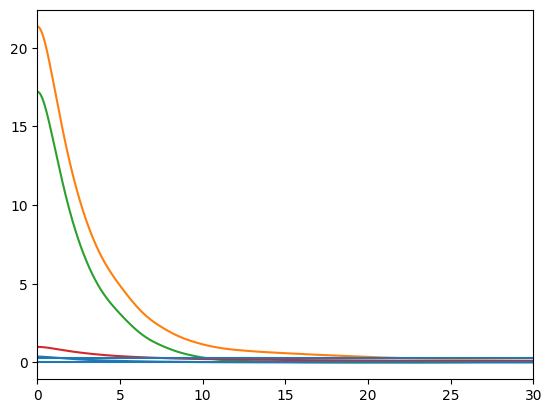

In [115]:
test_idx = 1

print("r var s", r_var_mean[test_idx], r_var_sq[test_idx])
print("r mod sq", r_mod_sq[test_idx])

plt.plot(jnp.arange(resolution * 30)/resolution, jnp.mean(r_acov_s[test_idx], axis = 0)[:resolution * 30])
plt.plot(jnp.arange(resolution * 30)/resolution, part_n * jnp.mean(r_ccov_s[test_idx][:,:,:resolution * 30] ** 2, 
                                                                   axis = (0,1)))
plt.plot(jnp.arange(resolution * 30)/resolution, part_n * rhatacov[:resolution * 30] ** 2)
plt.plot(jnp.arange(resolution * 30)/resolution, part_n * jnp.mean(r_tld_ccov_s[:,:,:resolution * 30] ** 2, 
                                                                   axis = (0,1)))
plt.hlines([0,jnp.mean(r_ccov_s[test_idx][:,:,resolution * 300] ** 2) * part_n], 0, 30)
plt.xlim(0,30)